**Author**: Sujan Tamang

## Breast Cancer Predictor
This work uses the mammogram image dataset from [mini-MIAS](http://peipa.essex.ac.uk/info/mias.html).

In [1]:
import tensorflow as tf

print(tf.__version__)

2.4.1


In [2]:
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential


image_size = 224
batch_size = 32
epochs = 10

# Image Dataset Directory
train_dir = "dataset/train/"
validation_dir = "dataset/valid/"
test_dir = "dataset/test/"

## VGG16 Base Architecture
![VGG16](./assets/vgg16.png)

In [3]:
def vgg16_finetuned():
    # Load the VGG model
    vgg_conv = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Freeze all the layers except the last 4 layers
    for layer in vgg_conv.layers[:-4]:
        layer.trainable = False

    # Check the trainable status of the individual layers
    # for layer in vgg_conv.layers:
    #     print(layer, layer.trainable)
    
    # Add new layers
    x = Flatten()(vgg_conv.output)
    y = Dense(1024, activation="relu")(x)
    z = Dropout(0.8)(y)
    out = Dense(2, activation="softmax")(z)
    
    model = Model(inputs=vgg_conv.input, outputs=out)

    return model


model = vgg16_finetuned()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Which layers are trainable?

In [4]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
flatten True
dense True
dropout True
dense_1 True


In [5]:
def show_graphs(history):
    # Plot the accuracy and loss curves
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs1 = range(len(acc))

    plt.plot(epochs1, acc, "b", label="Training acc")
    plt.plot(epochs1, val_acc, "r", label="Val acc")
    plt.title("Training & Validation accuracy")
    plt.legend()

#     plt.figure()
#     plt.plot(epochs1, loss, "b", label="Training loss")
#     plt.plot(epochs1, val_loss, "r", label="Validation loss")
#     plt.title("Training & Validation loss")
#     plt.legend()
    plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True)

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

validation_datagen = ImageDataGenerator(rescale=1. / 255)

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(image_size, image_size),
                                                              batch_size=batch_size,
                                                              class_mode="categorical",
                                                              shuffle=False)

Found 72 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

Epoch 1/10
3/3 [==============================] - 13s 5s/step - loss: 1.2515 - accuracy: 0.5292 - val_loss: 0.6901 - val_accuracy: 0.4375
Epoch 2/10
3/3 [==============================] - 12s 4s/step - loss: 1.4385 - accuracy: 0.4280 - val_loss: 0.6957 - val_accuracy: 0.6250
Epoch 3/10
3/3 [==============================] - 11s 5s/step - loss: 0.9970 - accuracy: 0.5444 - val_loss: 0.7174 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 12s 4s/step - loss: 1.0289 - accuracy: 0.5774 - val_loss: 0.7267 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 12s 5s/step - loss: 0.7499 - accuracy: 0.6681 - val_loss: 0.7280 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 12s 5s/step - loss: 0.9180 - accuracy: 0.5944 - val_loss: 0.7361 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 12s 5s/step - loss: 0.6875 - accuracy: 0.7076 - val_loss: 0.7410 - val_accuracy: 0.5000
Epoch 8/10
3/3 [==================

In [8]:
# Save model
today = datetime.today().strftime("%Y-%m-%d-%H%M")
current_trained_model_path = f"trained_models/vgg_trained_{today}_{epochs}_epoch.h5"
model.save(current_trained_model_path)

print(f"model save in {current_trained_model_path}")

model save in trained_models/vgg_trained_2021-05-13-1518_10_epoch.h5


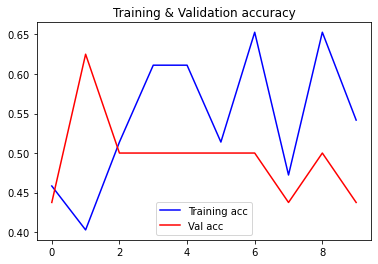

In [9]:
show_graphs(history)

## Testing

In [10]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Data Generator for Test data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False)

Found 27 images belonging to 2 classes.


In [11]:
trained_model = keras.models.load_model(current_trained_model_path)

In [12]:
trained_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# Get the filenames from the generator
fnames = test_generator.filenames
# print(fnames)  # gives the idea about the data stored in fnames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())

# Get the predictions from the model using the generator
print('predicting on the test images...')

predicting on the test images...


In [14]:
prediction_start = time.time()
predictions = trained_model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

In [15]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No. of errors = {}/{}".format(len(errors), test_generator.samples))

correct_predictions = np.where(predicted_classes == ground_truth)[0]
print("No. of correct predictions = {}/{}".format(len(correct_predictions), test_generator.samples))

print("Test Accuracy = {0:.2f}%".format(len(correct_predictions)*100/test_generator.samples))

No. of errors = 14/27
No. of correct predictions = 13/27
Test Accuracy = 48.15%


## Displaying correct predictions

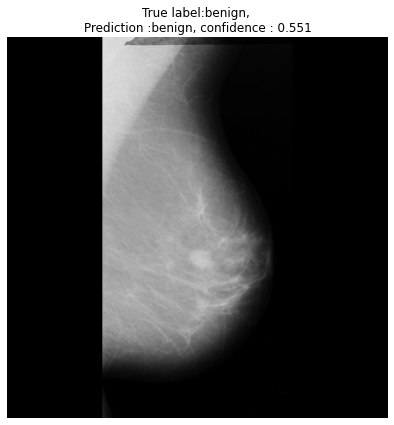

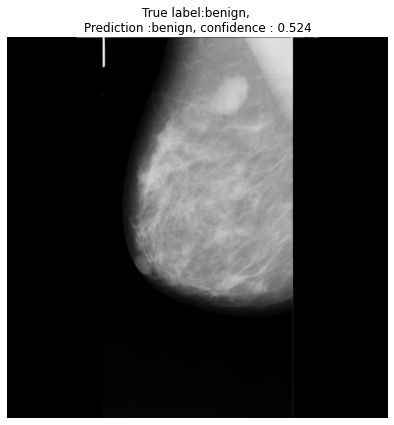

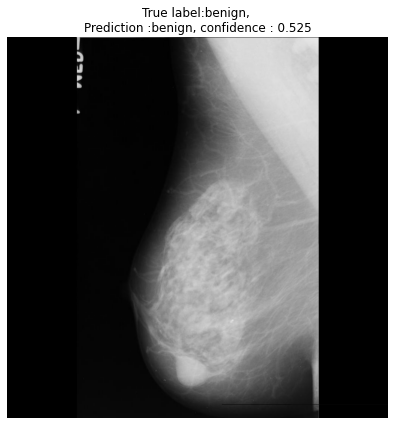

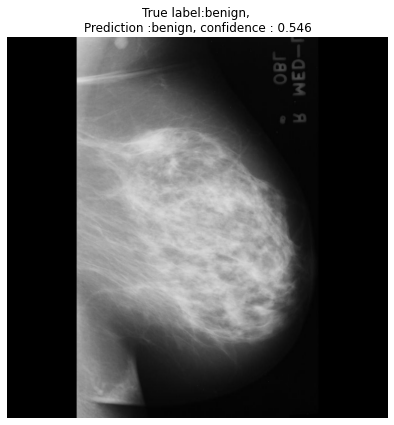

In [16]:
# Show the correct predictions
for i in range(4):
    pred_class = np.argmax(predictions[correct_predictions[i]])
    pred_label = idx2label[pred_class]

    title = "True label:{}, \nPrediction :{}, confidence : {:.3f}".format(
        fnames[correct_predictions[i]].split("/")[0],
        pred_label,
        predictions[correct_predictions[i]][pred_class])

    original = load_img("{}/{}".format(test_dir, fnames[correct_predictions[i]]))
    plt.figure(figsize=[7, 7])
    plt.axis("off")
    plt.title(title)
    # plt.savefig(str(i) + ".jpg")
    plt.imshow(original)
    plt.show()

## Displaying incorrect predictions

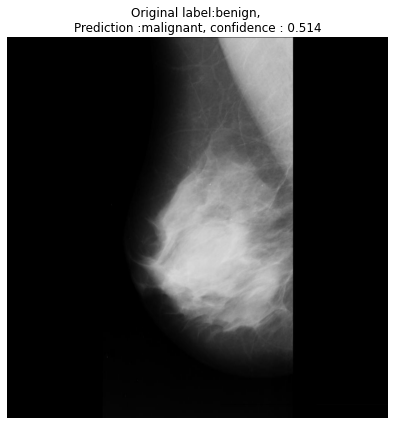

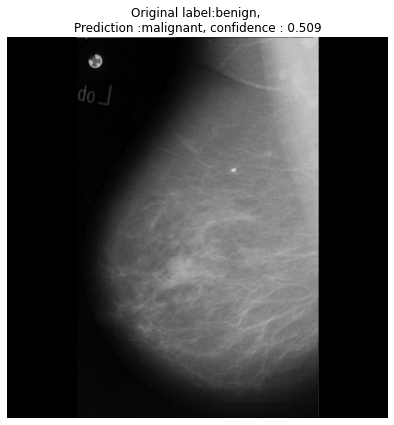

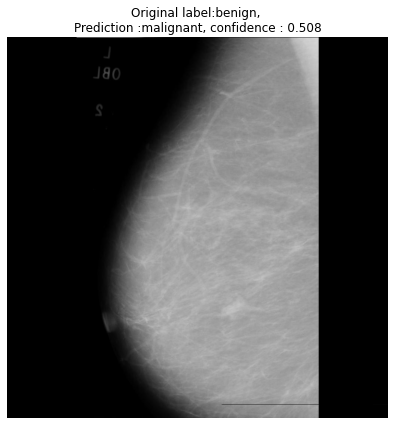

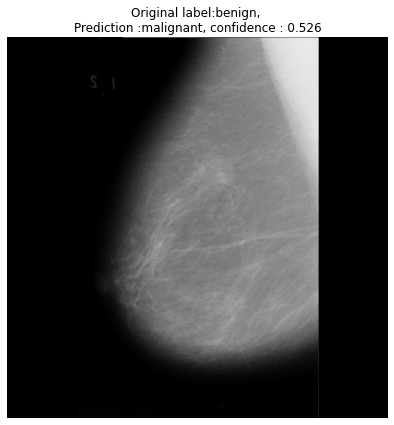

In [17]:
for i in range(4):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]

    title = "Original label:{}, \nPrediction :{}, confidence : {:.3f}".format(
        fnames[errors[i]].split("/")[0],
        pred_label,
        predictions[errors[i]][pred_class])

    original = load_img("{}/{}".format(test_dir, fnames[errors[i]]))
    plt.figure(figsize=[7, 7])
    plt.axis("off")
    plt.title(title)
    plt.imshow(original)
    # plt.savefig(str(i) + ".jpg")
    plt.show()